## Deep Learning Multiclass Challenge (CAD Project)

Author: **Muhammad Zain Amin**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

#### Libraries

In [ ]:
import copy
import time
import sys
import logging
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps
from typing import Optional, Sequence

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from skimage import io

#### Import Functions and Classes

In [20]:
from imshow import imshow
from visualize_model import visualize_model
from focal_loss import FocalLoss
from train_model import train_model
from test_model import test_model
from plot_confusion_matrix import plot_confusion_matrix
from plot_roc import plot_roc
from Imbalanced_Dataset_Sampler import ImbalancedDatasetSampler 
from Challenge_2_Dataset import Challenge2Dataset
from Data_Samples import get_samples_count
from models import ModelFactory

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset Directories

In [ ]:
# Image directories
train_img_folder = '/content/drive/MyDrive/CAD/Dataset/train/train'
val_img_folder = '/content/drive/MyDrive/CAD/Dataset/val/val'
test_img_folder = '/content/drive/MyDrive/CAD/Dataset/test'

# CSV paths
train_csv_path = '/content/drive/MyDrive/CAD/Dataset/train_labels.csv'
val_csv_path = '/content/drive/MyDrive/CAD/Dataset/val_labels.csv'
test_csv_path = '/content/drive/MyDrive/CAD/Dataset/test_ids.csv'

#### Parameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
NEW_SIZE = 256
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 2
MU = [0.6138, 0.5056, 0.4985]
STD = [0.1611, 0.1672, 0.1764]

#### Data Transformations

In [ ]:
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= MU, std=STD)
                                  ])

In [ ]:
dataset_train = Challenge2Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             img_transform = img_transforms,
                             augment = True)

In [ ]:
dataset_val = Challenge2Dataset(csv_file=val_csv_path,
                            image_folder= val_img_folder,
                            img_transform = img_transforms,
                            augment=False)


#### Data Loaders

In [ ]:
y = dataset_train.get_labels()
class_weights= class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y), y= np.array(y))
class_weights =  torch.tensor(class_weights).float().to(DEVICE)

In [ ]:
# Balanced training dataloader
mean_samples = get_samples_count(dataset_train.get_labels(), 'mean') 
data_sampler = ImbalancedDatasetSampler(dataset_train, indices=None, num_samples=mean_samples, replacement = True)
train_loader_balanced = DataLoader(dataset_train, sampler=data_sampler, num_workers=NUM_WORKERS,
                             batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loader_shuff = DataLoader(dataset_val, batch_size=8, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
# dataloaders with the original number of samples in the dataset
train_loader = DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)


In [ ]:
dataloaders = {"train": train_loader,"val": val_loader}
dataloaders_balanced = {"train": train_loader_balanced,"val": val_loader}

# Training and Results

### Swin B V2

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/CAD/Swin/swin_b_v2_ce.txt", level=logging.INFO,format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/CAD/Swin'

In [ ]:
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-8
model_factory = ModelFactory()
swin = model_factory.make_swin_v2_b(True, DEVICE)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(swin.parameters(), lr = LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth
100%|██████████| 336M/336M [00:18<00:00, 18.7MB/s]


In [ ]:
logging.info('Model:swin_b_v2, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, without sampling')

Model:swin_b_v2, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, without sampling


In [ ]:
#number of samples in each set
dataset_sizes = {'train': len(dataset_train),'val':len(dataset_val)}

In [ ]:
checkpoint_p = '/content/drive/MyDrive/CAD/swin_b_v2_ce.pth'
swin = train_model(swin, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train epoch 1 : loss : 0.5687, acc: 0.7847, kappa: 0.5949



100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

val epoch 1 : loss : 0.4870, acc: 0.8110, kappa: 0.6551



Epoch 2/100
---------------


100%|██████████| 318/318 [02:27<00:00,  2.16it/s]

train epoch 2 : loss : 0.4275, acc: 0.8453, kappa: 0.7117



100%|██████████| 20/20 [00:28<00:00,  1.43s/it]

val epoch 2 : loss : 0.3557, acc: 0.8638, kappa: 0.7491



Epoch 3/100
---------------


100%|██████████| 318/318 [02:26<00:00,  2.17it/s]

train epoch 3 : loss : 0.3775, acc: 0.8636, kappa: 0.7482



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 3 : loss : 0.3774, acc: 0.8496, kappa: 0.7229



Epoch 4/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]


train epoch 4 : loss : 0.3271, acc: 0.8813, kappa: 0.7819


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

val epoch 4 : loss : 0.3562, acc: 0.8677, kappa: 0.7691



Epoch 5/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.20it/s]

train epoch 5 : loss : 0.3193, acc: 0.8851, kappa: 0.7895



100%|██████████| 20/20 [00:28<00:00,  1.40s/it]

val epoch 5 : loss : 0.2466, acc: 0.9173, kappa: 0.8506



Epoch 6/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.22it/s]

train epoch 6 : loss : 0.2664, acc: 0.9018, kappa: 0.8210



100%|██████████| 20/20 [00:28<00:00,  1.40s/it]

val epoch 6 : loss : 0.2272, acc: 0.9142, kappa: 0.8456



Epoch 7/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]


train epoch 7 : loss : 0.2532, acc: 0.9034, kappa: 0.8242


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 7 : loss : 0.2838, acc: 0.9102, kappa: 0.8376



Epoch 8/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.23it/s]

train epoch 8 : loss : 0.2277, acc: 0.9183, kappa: 0.8518



100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

val epoch 8 : loss : 0.2434, acc: 0.9094, kappa: 0.8378



Epoch 9/100
---------------


100%|██████████| 318/318 [02:24<00:00,  2.20it/s]

train epoch 9 : loss : 0.1990, acc: 0.9299, kappa: 0.8729



100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

val epoch 9 : loss : 0.2083, acc: 0.9244, kappa: 0.8646



Epoch 10/100
---------------


100%|██████████| 318/318 [02:23<00:00,  2.22it/s]

train epoch 10 : loss : 0.1986, acc: 0.9235, kappa: 0.8612



100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

val epoch 10 : loss : 0.2220, acc: 0.9173, kappa: 0.8481



Epoch 11/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train epoch 11 : loss : 0.1919, acc: 0.9305, kappa: 0.8742



100%|██████████| 20/20 [00:28<00:00,  1.42s/it]

val epoch 11 : loss : 0.2406, acc: 0.9213, kappa: 0.8565



Epoch 12/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train epoch 12 : loss : 0.1668, acc: 0.9392, kappa: 0.8899



100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

val epoch 12 : loss : 0.2577, acc: 0.9181, kappa: 0.8482



Epoch 13/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.24it/s]

train epoch 13 : loss : 0.1555, acc: 0.9416, kappa: 0.8944



100%|██████████| 20/20 [00:28<00:00,  1.40s/it]

val epoch 13 : loss : 0.2092, acc: 0.9331, kappa: 0.8810



Epoch 14/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train epoch 14 : loss : 0.1610, acc: 0.9420, kappa: 0.8951



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

val epoch 14 : loss : 0.2063, acc: 0.9291, kappa: 0.8739



Epoch 15/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train epoch 15 : loss : 0.1441, acc: 0.9461, kappa: 0.9026



100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

val epoch 15 : loss : 0.1629, acc: 0.9417, kappa: 0.8946



Epoch 16/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train epoch 16 : loss : 0.1351, acc: 0.9538, kappa: 0.9165



100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

val epoch 16 : loss : 0.1893, acc: 0.9417, kappa: 0.8953



Epoch 17/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train epoch 17 : loss : 0.1306, acc: 0.9540, kappa: 0.9167



100%|██████████| 20/20 [00:28<00:00,  1.40s/it]

val epoch 17 : loss : 0.1836, acc: 0.9425, kappa: 0.8955



Epoch 18/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train epoch 18 : loss : 0.1124, acc: 0.9624, kappa: 0.9322



100%|██████████| 20/20 [00:27<00:00,  1.35s/it]

val epoch 18 : loss : 0.3004, acc: 0.9157, kappa: 0.8490



Epoch 19/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]


train epoch 19 : loss : 0.1266, acc: 0.9551, kappa: 0.9190


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 19 : loss : 0.1714, acc: 0.9465, kappa: 0.9039



Epoch 20/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train epoch 20 : loss : 0.1160, acc: 0.9587, kappa: 0.9254



100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

val epoch 20 : loss : 0.2400, acc: 0.9370, kappa: 0.8857



Epoch 21/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train epoch 21 : loss : 0.1154, acc: 0.9614, kappa: 0.9303



100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

val epoch 21 : loss : 0.2497, acc: 0.9291, kappa: 0.8733



Epoch 22/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train epoch 22 : loss : 0.1033, acc: 0.9624, kappa: 0.9322



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

val epoch 22 : loss : 0.2078, acc: 0.9417, kappa: 0.8940



Epoch 23/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]

train epoch 23 : loss : 0.1088, acc: 0.9608, kappa: 0.9294



100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

val epoch 23 : loss : 0.2054, acc: 0.9260, kappa: 0.8650



Epoch 24/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train epoch 24 : loss : 0.0719, acc: 0.9742, kappa: 0.9535



100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

val epoch 24 : loss : 0.1495, acc: 0.9575, kappa: 0.9235



Epoch 25/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train epoch 25 : loss : 0.0533, acc: 0.9811, kappa: 0.9660



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 25 : loss : 0.1396, acc: 0.9614, kappa: 0.9308



Epoch 26/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train epoch 26 : loss : 0.0373, acc: 0.9878, kappa: 0.9780



100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

val epoch 26 : loss : 0.1451, acc: 0.9685, kappa: 0.9434



Epoch 27/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train epoch 27 : loss : 0.0304, acc: 0.9906, kappa: 0.9830



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 27 : loss : 0.1451, acc: 0.9685, kappa: 0.9434



Epoch 28/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train epoch 28 : loss : 0.0295, acc: 0.9906, kappa: 0.9830



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

val epoch 28 : loss : 0.1553, acc: 0.9669, kappa: 0.9406



Epoch 29/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]

train epoch 29 : loss : 0.0238, acc: 0.9919, kappa: 0.9855



100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

val epoch 29 : loss : 0.1523, acc: 0.9677, kappa: 0.9421



Epoch 30/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]


train epoch 30 : loss : 0.0241, acc: 0.9917, kappa: 0.9851


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

val epoch 30 : loss : 0.1656, acc: 0.9669, kappa: 0.9405



Epoch 31/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.27it/s]


train epoch 31 : loss : 0.0254, acc: 0.9908, kappa: 0.9834


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

val epoch 31 : loss : 0.1616, acc: 0.9614, kappa: 0.9307



Epoch 32/100
---------------


100%|██████████| 318/318 [02:19<00:00,  2.28it/s]


train epoch 32 : loss : 0.0254, acc: 0.9913, kappa: 0.9844


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 32 : loss : 0.1451, acc: 0.9685, kappa: 0.9434



Epoch 33/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.24it/s]

train epoch 33 : loss : 0.0225, acc: 0.9929, kappa: 0.9873



100%|██████████| 20/20 [00:27<00:00,  1.40s/it]

val epoch 33 : loss : 0.1524, acc: 0.9638, kappa: 0.9347



Epoch 34/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.26it/s]

train epoch 34 : loss : 0.0147, acc: 0.9947, kappa: 0.9904



100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

val epoch 34 : loss : 0.1510, acc: 0.9669, kappa: 0.9405



Epoch 35/100
---------------


100%|██████████| 318/318 [02:21<00:00,  2.25it/s]

train epoch 35 : loss : 0.0215, acc: 0.9925, kappa: 0.9865



100%|██████████| 20/20 [00:27<00:00,  1.35s/it]

val epoch 35 : loss : 0.1486, acc: 0.9693, kappa: 0.9448



Epoch 36/100
---------------


100%|██████████| 318/318 [02:22<00:00,  2.24it/s]

train epoch 36 : loss : 0.0185, acc: 0.9939, kappa: 0.9890



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 36 : loss : 0.1467, acc: 0.9701, kappa: 0.9462



Epoch 37/100
---------------


100%|██████████| 318/318 [02:20<00:00,  2.27it/s]

train epoch 37 : loss : 0.0178, acc: 0.9945, kappa: 0.9901



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 37 : loss : 0.1437, acc: 0.9709, kappa: 0.9476



Epoch 38/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train epoch 38 : loss : 0.0180, acc: 0.9933, kappa: 0.9880



100%|██████████| 20/20 [00:28<00:00,  1.40s/it]

val epoch 38 : loss : 0.1436, acc: 0.9724, kappa: 0.9505


EARLY STOP AFTER 38 EPOCHS
Training complete in 111m 59s
Best val loss: 0.139601
Best val Kappa: 0.9504636027281238


#### Load the saved model

In [ ]:
swin_b_best_1 = model_factory.make_swin_v2_b(False, DEVICE)
swin_b_best_1.load_state_dict(torch.load('/content/drive/MyDrive/CAD/swin_b_v2_ce_best.pth'))

<All keys matched successfully>

In [ ]:
since = time.time()

swin_b_best_1.eval()
running_labels = []
running_preds = []
outputs_all = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs = swin_b_best_1(inputs)
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
        probas = F.softmax(outputs, dim=1)
        outputs_all.append(probas.cpu().numpy())
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')
    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:29<00:00,  1.49s/it]

Test Acc: 0.9724, kappa: 0.9505
Testing complete in 0m 30s


Confusion matrix, without normalization
[[664   9   5]
 [  7 486   5]
 [  4   5  85]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

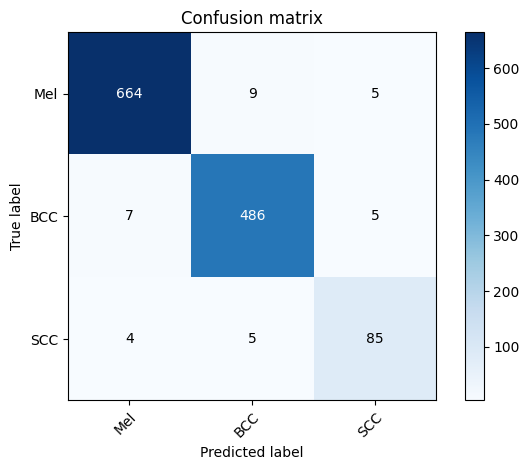

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

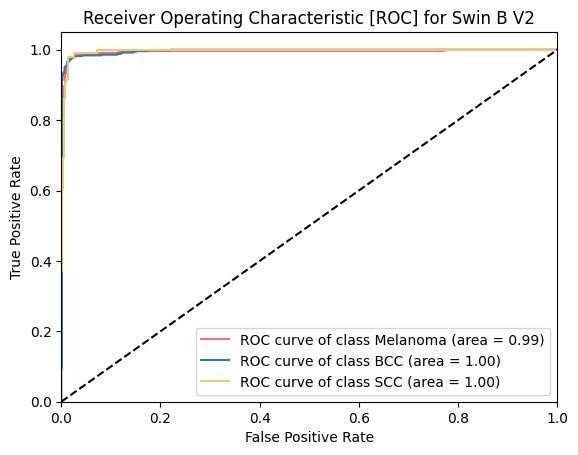

{0: 0.9941675635812804, 1: 0.9959449195746717, 2: 0.9962006079027356}

In [ ]:
probas = np.vstack(outputs_all)

plot_roc(running_labels, probas, True, 'Swin B V2')

In [ ]:
test_df = pd.read_csv(test_csv_path)
test_ids = []
test_preds = []
for i, row in test_df.iterrows():

  img_path = test_img_folder + img_id + '.jpg' 
  image = Image.open(img_path) 
  image = img_transforms(image).unsqueeze(0).to(DEVICE)

  outputs_1 = swin_b_best_1(image)
  outputs = outputs_1
  _, preds = torch.max(outputs, 1)
  test_preds = test_preds + preds.int().cpu().tolist()
  test_ids.append(img_id)
  print(f"Image {row['Image_ID']} done")

Image xxx01102 done
Image xxx01122 done
Image xxx01137 done
Image xxx01096 done
Image xxx01126 done
Image xxx01121 done
Image xxx01089 done
Image xxx01095 done
Image xxx01087 done
Image xxx01109 done
Image xxx01110 done
Image xxx01107 done
Image xxx01091 done
Image xxx01125 done
Image xxx01082 done
Image xxx01101 done
Image xxx01156 done
Image xxx01195 done
Image xxx01158 done
Image xxx01180 done
Image xxx01181 done
Image xxx01189 done
Image xxx01188 done
Image xxx01148 done
Image xxx01162 done
Image xxx01182 done
Image xxx01147 done
Image xxx01179 done
Image xxx01138 done
Image xxx01170 done
Image xxx01171 done
Image xxx01174 done
Image xxx01160 done
Image xxx01164 done
Image xxx01161 done
Image xxx01173 done
Image xxx01153 done
Image xxx01178 done
Image xxx01145 done
Image xxx01152 done
Image xxx01142 done
Image xxx01191 done
Image xxx01143 done
Image xxx01193 done
Image xxx01155 done
Image xxx01194 done
Image xxx01200 done
Image xxx01184 done
Image xxx01196 done
Image xxx01144 done


In [ ]:
test_dict = {'img_id': test_ids, 'prediction': test_preds}
test_inf_df = pd.DataFrame(test_dict)
test_inf_df.to_csv('/content/drive/MyDrive/CAD/test_results_swin_b_v2.csv')